---
title: "SHAP values"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## simple practical example

Let's say I want to know what impacts the price of a car. I have a model that takes into account 2 features, the car's age ($x_1$) and the car's mileage ($x_2$).
We call the set of all features $N = \{x_1, x_2\}$.

Assume that we have a database with $n$ cars, and we somehow arrived at a model $f(x_1, x_2)$ that predicts the price of a car based on its age and mileage. Now, we want to understand how much each feature contributes to the predicted price for a **specific car** $(x_1^\star, x_2^\star)$ in our database. More specifically, we are asking:

**Relative to the average price of all cars in the database, how many dollars of this specific car's price can be attributed to its age ($x_1^\star$​) and how many to its mileage ($x_2^\star$)?**

This can be answered by the formula below.

$$
\phi_j = \sum_{S \subseteq N \setminus \{j\}} \binom{n-1}{|S|}^{-1}[f(S \cup \{j\}) - f(S)].
$$

To compute the SHAP value $\phi_1$ for the car's age ($x_1$), we subtract age from the set of all features (that is, $N \setminus \{x_1\}=\{x_2\}$), and consider all possible subsets in that, which are the empty set $S_0 = \{\}$, and the set $S_1 = \{x_2\}$. This is what we are summing over in the formula above.

The parenthesis with a $-1$ power is the binomial coefficient, which is a normalization factor that accounts for the number of subsets of a given size. In our example, since we have 1 feature in $N \setminus \{x_1\}=\{x_2\}$, we have $\binom{1}{0} = 1$ for the empty set, $\binom{1}{1} = 1$ for subsets of size 1.

The last part of the formula, $f(S \cup \{j\}) - f(S)$, represents the marginal contribution of feature $x_j$ (here, price $x_1$) when added to the subset $S$. Let's spell it out for our example:

\begin{align*}
\phi_1 &= \binom{1}{0}^{-1}[f(\{x_1\}) - f(\{\})] + \binom{1}{1}^{-1}[f(\{x_1, x_2\}) - f(\{x_2\})] \\
&= [f(\{x_1\}) - f(\{\})] + [f(\{x_1, x_2\}) - f(\{x_2\})].
\end{align*}

Intuitively, the expression above is asking: **How much does the predicted price change when we add the car's age to our model, first when we have no other information (the empty set), and then when we already know the car's mileage?**

We need now to find the values of $f(\{\})$, $f(\{x_1\})$, $f(\{x_2\})$, and $f(\{x_1, x_2\})$ to compute $\phi_1$. Let's see what each means:

* $f(\{\})$ is the expected price of a car when we ignore both age and mileage.
* $f(\{x_1\})$ is the expected price of a car when we only consider its age, ignoring mileage.
* $f(\{x_2\})$ is the expected price of a car when we only consider its mileage, ignoring age.
* $f(\{x_1, x_2\})$ is the expected price of a car when we consider both age and mileage.

Let's start with $f(\{\})$. This is the expected price of a car when we ignore both age and mileage. I find it more illuminating to phrase this as a question: **If I have a car, and I don't know its age or milage, what is the expected price based on the typical ages and mileages of cars in my database?**
We can compute this by averaging the model's predictions over all possible values of age and mileage:

$$
f(\{\}) = \mathbb{E}[f(x)] = \int f(x_1, x_2) p(x_1, x_2) dx_1 dx_2.
$$

Because we have a finite dataset of $n$ cars, we can approximate this integral by taking the average of the model's predictions for all $n$ cars in our database:

$$
f(\{\}) = \frac{1}{n} \sum_{i=1}^{n} f(x_1^i, x_2^i).
$$

Let's visualize this. The figure below shows the price of the car (the color) as a function of its age and mileage. The black dots represent the $n$ cars in our database.

In [1]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
# %matplotlib widget

In [2]:
#| code-summary: "model definition and sample data generation"
def model_f(x1, x2):
    return 2 + 0.5 * 0.3*x1**2 + x2 + (0.3 * x1 * x2) + 3*np.exp((-(x1+1)**2 - (x2-1)**2)/0.3) - 3*np.exp((-(x1-1)**2 - (x2+1)**2)/0.3)

N = 40
rng = np.random.default_rng(seed=1)
x1_min = -2; x1_max = 2
x2_min = -2; x2_max = 2
x1_sample = rng.uniform(x1_min, x1_max, size=N)
x2_sample = rng.uniform(x2_min, x2_max, size=N)
z_sample = model_f(x1_sample, x2_sample)

# 2. Create the feature space (The Domain)
x1_range = np.linspace(x1_min, x1_max, 50)
x2_range = np.linspace(x2_min, x2_max, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = model_f(X1, X2)

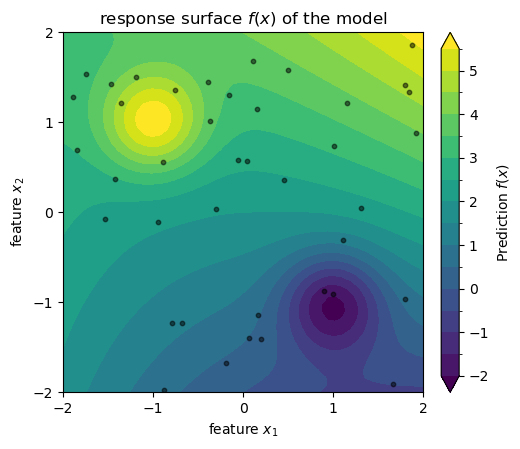

In [3]:
#| code-summary: "2d plot"
fig, ax = plt.subplots(figsize=(6, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
levels = np.arange(-2, 6, 0.5)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256, extend='both')
cpax = ax.contourf(X1, X2, Z, levels=levels, cmap=cm.viridis, norm=norm, extend='both')
cax = ax.inset_axes([1.05, 0.0, 0.05, 1.0], transform=ax.transAxes)
cbar = fig.colorbar(cpax, cax=cax)
cbar.set_label(r"Prediction $f(x)$ ")
ax.set_aspect('equal')
ax.set(
    xlabel=r"feature $x_1$",
    ylabel=r"feature $x_2$",
    title=r"response surface $f(x)$ of the model",
    xticks=np.arange(-2, 3, 1),
    yticks=np.arange(-2, 3, 1)
);

ax.scatter(x1_sample, x2_sample, c='k', s=10, alpha=0.5, label='Sample Points')


Another way to see this is by plotting the model's predictions as the height of the surface above the age-mileage plane.

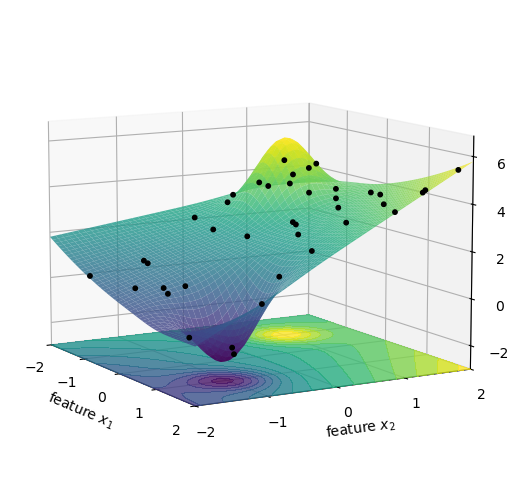

In [4]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
ax.scatter(x1_sample, x2_sample, z_sample, c='k', s=10, alpha=1.0, label='Sample Points')

z_offset = -3

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

$f(\{\})$ is the average height of all the black dots in the figure above. This is the expected price of a car when we don't know its age or mileage, and use instead the typical ages and mileages of cars in our database. We represent the result as the gray horizontal plane in the figure below.

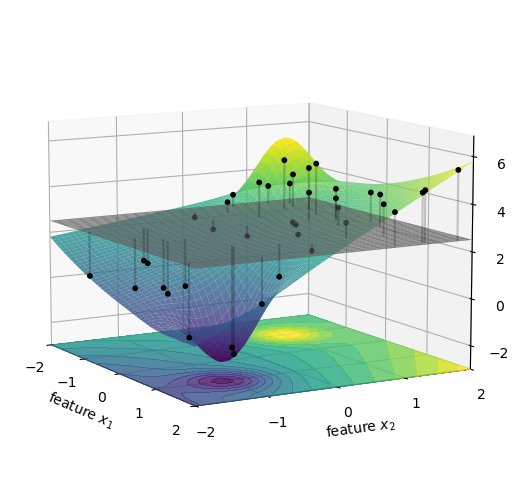

In [5]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
ax.scatter(x1_sample, x2_sample, z_sample, c='k', s=10, alpha=1.0, label='Sample Points')

z_offset = -3

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.8, antialiased=True)

for i in range(N):
    ax.plot([x1_sample[i]]*2, [x2_sample[i]]*2, [phi_0, z_sample[i]], 'k-', alpha=0.2)


ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)



Now let's compute $f(\{x_1\})$. This is the expected price of a specific car when we only consider its age, ignoring mileage. Phrasing this as a question: **If I have a 5-year-old car, but I don't know its mileage, what is its expected price based on the typical mileages I see in my data?**

In integral form, this can be expressed as:

$$
f(\{x_1\}) = \mathbb{E}[f(x) | x_1] = \int f(x_1, x_2) p(x_2) dx_2.
$$

We can compute this by averaging the model's predictions over all possible values of mileage, while keeping age fixed:

$$
f(\{x_1\}) = \frac{1}{n} \sum_{i=1}^{n} f(x_1^\star, x_2^i),
$$
where $x_1^\star$ is the age of the specific car we are trying to explain, and $x_2^i$ are the mileages of all cars in our database.

Let's visualize this. The figure below shows a specific car in our database as a red dot. The pink vertical plane is located at the age of this car, and we marked the intersection of this plane with the surface as a red curve. All the black dots, previously located at their original age and mileage, were brought to this pink plane. We did that just by shifting their $x_1$ value to $x_1^\star$, while keeping their $x_2$ and $z$ values the same. I imagine this as squishing the dots along the $x_1$ axis, until they all lie on the pink plane.

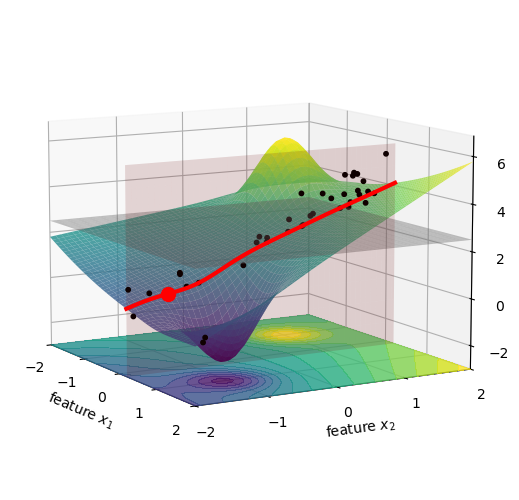

In [7]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
idx = 8

ax.scatter(np.full_like(x1_sample, x1_sample[idx]), x2_sample, z_sample, c='k', s=10, alpha=1.0, label='Sample Points')

z_offset = -3

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)


x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x2 = np.linspace(-2, 2, 100)
slice_x1 = np.full_like(slice_x2, x1_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')

# Plot the specific prediction point (y_hat)
ax.scatter([x1_sample[idx]], [x2_sample[idx]], [z_sample[idx]], color='red', s=100, label='Prediction (y_hat)', zorder=10)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x2_mesh, z_mesh = np.meshgrid(slice_x2, z_plane_range)
slice_x1_mesh = np.full_like(slice_x2_mesh, x1_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)



Now we compute the values for $f(x_1^\star, x_2^i)$. This is the same as taking all the black dots in the figure above, and moving them vertically to the red line, see below.

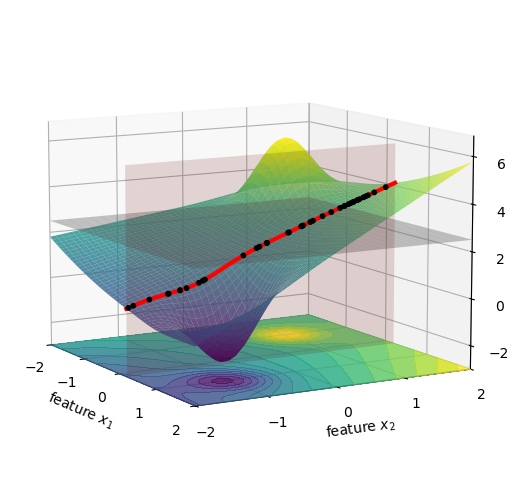

In [8]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
x1_squished = np.full_like(x1_sample, x1_sample[idx])
ax.scatter(x1_squished, x2_sample, model_f(x1_squished, x2_sample), c='k', s=10, alpha=1.0, zorder=11)

z_offset = -3

# Plot the 2D contour projected on the 3D 'floor'
ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)



x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x2 = np.linspace(-2, 2, 100)
slice_x1 = np.full_like(slice_x2, x1_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')

# Plot the specific prediction point (y_hat)
# ax.scatter([x1_sample[idx]], [x2_sample[idx]], [z_sample[idx]], color='red', s=100, label='Prediction (y_hat)', zorder=10)

# Plot the Marginal Slice (The path SHAP integrates over)
# ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')


phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

# for i in range(N):
#     ax.plot([x1_sample[i]]*2, [x2_sample[i]]*2, [phi_0, z_sample[i]], 'k-', alpha=0.2)


z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x2_mesh, z_mesh = np.meshgrid(slice_x2, z_plane_range)
slice_x1_mesh = np.full_like(slice_x2_mesh, x1_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)



We can average the height of all these new black dots, which is shown below as a black horizontal line, and this will give us the value of $f(\{x_1\})$.

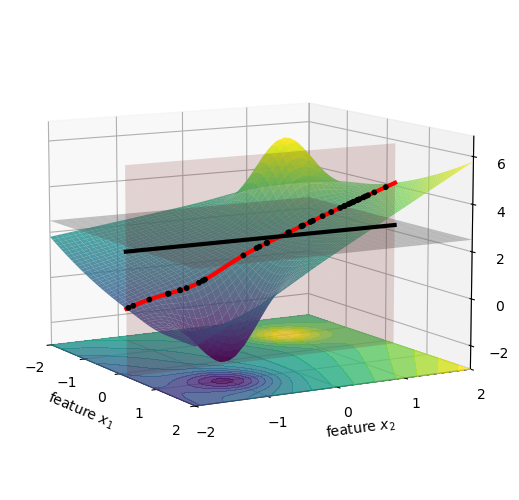

In [10]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
x1_squished = np.full_like(x1_sample, x1_sample[idx])
x2_squished = np.full_like(x2_sample, x2_sample[idx])
z_x1squished = model_f(x1_squished, x2_sample)
z_x2squished = model_f(x1_sample, x2_squished)
ax.scatter(x1_squished, x2_sample, z_x1squished, c='k', s=10, alpha=1.0, zorder=11)

z_x1 = np.mean(z_x1squished)
z_x2 = np.mean(z_x2squished)

z_offset = -3

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

idx = 8
x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x2 = np.linspace(-2, 2, 100)
slice_x1 = np.full_like(slice_x2, x1_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')
ax.plot(slice_x1, slice_x2, np.full_like(slice_x2, z_x1), color='black', linewidth=3)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x2_mesh, z_mesh = np.meshgrid(slice_x2, z_plane_range)
slice_x1_mesh = np.full_like(slice_x2_mesh, x1_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

We are now ready to compute the first term for $\phi_1$, namely $f(\{x_1\}) - f(\{\})$. Visually, this is the distance between the black horizontal line and the gray horizontal plane in the figure above. This value is not very large, so we just can't quite see it in the figure, but it's there. We print its value below:

In [15]:
first_term = z_x1 - phi_0
print(f"{first_term:.3f}")

-0.244


Next, we compute $f(\{x_2\})$. This is the expected price of a specific car when we only consider its mileage, ignoring age. Phrasing this as a question: **If I have a car with 100,000 miles, but I don't know its age, what is its expected price based on the typical ages I see in my data?**

In integral form, this can be expressed as:

$$
f(\{x_2\}) = \mathbb{E}[f(x) | x_2] = \int f(x_1, x_2) p(x_1) dx_1.
$$

We can compute this by averaging the model's predictions over all possible values of age, while keeping mileage fixed:

$$
f(\{x_2\}) = \frac{1}{n} \sum_{i=1}^{n} f(x_1^i, x_2^\star),
$$
where $x_2^\star$ is the mileage of the specific car we are trying to explain, and $x_1^i$ are the ages of all cars in our database.

Visually, this is almost the same as what we did in the figures above for $x_1$, but now on the other axis.

Finally, we compute $f(\{x_1, x_2\})$. This is the expected price of a specific car when we consider both age and mileage. Phrasing this as a question: **If I have a 5-year-old car with 100,000 miles, what does my model predict its price to be?**

The expectation operator now becomes trivial:
$$
f(\{x_1, x_2\}) = \mathbb{E}[f(x) | x_1, x_2] = f(x_1^\star, x_2^\star).
$$

Since we are conditioning on both age and mileage, we can directly use the model's prediction for the specific car we are trying to explain, which is $f(x_1^\star, x_2^\star)$.

Now we are ready to compute the second term for $\phi_1$, namely $f(\{x_1, x_2\}) - f(\{x_2\})$. Visually, it is the vertical distance between the black horizontal line and the actual height of the car we are trying to explain, which is the blue dot in the figure above. We print its value below:

In [16]:
second_term = model_f(x1_sample[idx], x2_sample[idx]) - z_x2
print(f"{second_term:.3f}")

-0.146


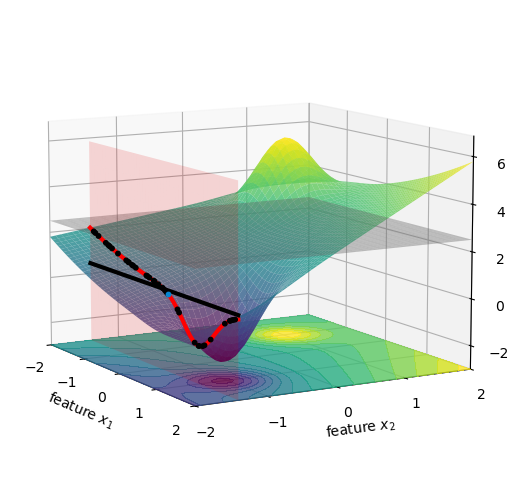

In [24]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
x1_squished = np.full_like(x1_sample, x1_sample[idx])
x2_squished = np.full_like(x2_sample, x2_sample[idx])
z_x1squished = model_f(x1_squished, x2_sample)
z_x2squished = model_f(x1_sample, x2_squished)
# ax.scatter(x1_squished, x2_sample, z_x1squished, c='k', s=10, alpha=1.0, zorder=11)
ax.scatter(x1_sample, x2_squished, z_x2squished, c='k', s=10, alpha=1.0, zorder=11)

ax.scatter(x1_sample[idx], x2_sample[idx], z_sample[idx], c='xkcd:cerulean', s=10, alpha=1.0, zorder=12)


z_x1 = np.mean(z_x1squished)
z_x2 = np.mean(z_x2squished)

z_offset = -3

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

idx = 8
x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x1 = np.linspace(-2, 2, 100)
slice_x2 = np.full_like(slice_x1, x2_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x2})')
ax.plot(slice_x1, slice_x2, np.full_like(slice_x2, z_x2), color='black', linewidth=3)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x1_mesh, z_mesh = np.meshgrid(slice_x1, z_plane_range)
slice_x2_mesh = np.full_like(slice_x1_mesh, x2_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

Finally, we can compute $\phi_1$ by summing the two terms we just computed:

In [23]:
phi_1 = first_term + second_term
print(f"phi_1 = {phi_1:.3f}")

phi_1 = -0.389


If you read all the code above that produced the figures, you might think that the computation is convoluted. Nothing could be further from the truth. See below the whole thing:

In [26]:
E_empty = np.mean(z_sample)
E_x1 = np.mean(model_f(x1_sample[idx], x2_sample))
E_x2 = np.mean(model_f(x1_sample, x2_sample[idx]))
E_x1x2 = model_f(x1_sample[idx], x2_sample[idx])
phi_1b = (E_x1 - E_empty) + (E_x1x2 - E_x2)
phi_2 = (E_x2 - E_empty) + (E_x1x2 - E_x1)
print(f"phi_1 = {phi_1b:.3f}")
print(f"phi_2 = {phi_2:.3f}")

phi_1 = -0.389
phi_2 = -4.007


The computation is so trivial that I can do it for the whole dataset and visualize the SHAP values for all cars in my database, as shown below.

In [27]:
phi1_list = []
phi2_list = []
for i in range(N):
    E_empty = np.mean(z_sample)
    E_x1 = np.mean(model_f(x1_sample[i], x2_sample))
    E_x2 = np.mean(model_f(x1_sample, x2_sample[i]))
    E_x1x2 = model_f(x1_sample[i], x2_sample[i])
    phi_1b = (E_x1 - E_empty) + (E_x1x2 - E_x2)
    phi_2 = (E_x2 - E_empty) + (E_x1x2 - E_x1)
    phi1_list.append(phi_1b)
    phi2_list.append(phi_2)

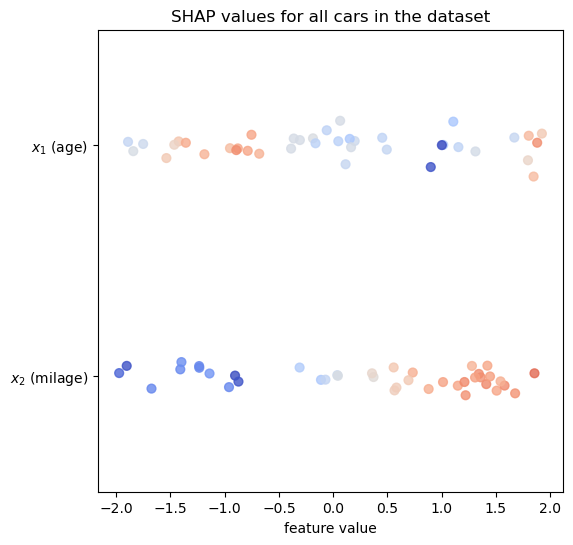

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
rng = np.random.default_rng(seed=1)
vertical_jitter = rng.normal(0, 0.05, size=N)
vabs1 = np.max(np.abs(phi1_list))
vabs2 = np.max(np.abs(phi2_list))
phi1_norm = colors.TwoSlopeNorm(vmin=-vabs1, vcenter=0, vmax=vabs1)
phi2_norm = colors.TwoSlopeNorm(vmin=-vabs2, vcenter=0, vmax=vabs2)

sc = ax.scatter(
    x1_sample,
    1 + vertical_jitter,
    c=phi1_list,
    cmap='coolwarm',
    norm=phi1_norm,
    alpha=0.8,
    s=40,
    label='SHAP value for $x_1$ (age)'
)
# fig.colorbar(sc, ax=ax, label=r'$\phi_1$')
vertical_jitter = rng.normal(0, 0.05, size=N)
sc = ax.scatter(
    x2_sample,
    0 + vertical_jitter,
    c=phi2_list,
    cmap='coolwarm',
    norm=phi2_norm,
    alpha=0.8,
    s=40,
    label='SHAP value for $x_2$ (income)'
)
ax.set(ylim=(-0.5, 1.5),
       xlabel=r'feature value',
       title='SHAP values for all cars in the dataset',
       yticks=[0, 1],
       yticklabels=['$x_2$ (milage)', '$x_1$ (age)']);


## unfinished

* Now I need to discuss the general case, when we have more than 2 features.
* Discuss the properties of SHAP values, show its decomposition.
* Show how to compute SHAP in python.


A useful way to understant the usefulness of SHAP values is by the SHAP decomposition. If $f(x)$ is the model's prediction for a specific data point $x$, the decomposition is:

$$
f(x) = \phi_0 + \sum_{j=1}^n \phi_j,
$$

where we have $M$ features. The SHAP values $\phi_j$ represent the contribution of each feature to the prediction, beyond the average prediction $\phi_0$.